In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt




In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/plants/plant-seedlings-classification-.zip","r") as zip_ref:
    zip_ref.extractall("/content/plants/")

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from os.path import join, isdir
from os import listdir, makedirs, getcwd, remove
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
import random
from collections import deque

use_cuda = torch.cuda.is_available()
use_cuda

True

In [7]:
manualSeed = 999
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
fixSeed(manualSeed)

In [8]:
import os

def find_classes(fullDir):
    classes = [d for d in os.listdir(fullDir) if os.path.isdir(os.path.join(fullDir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    num_to_class = dict(zip(range(len(classes)), classes))
    
    train = []
    for index, label in enumerate(classes):
      path = fullDir + label + '/'
      for file in listdir(path):
        train.append(['{}/{}'.format(label, file), label, index])
    
    df = pd.DataFrame(train, columns=['file', 'category', 'category_id', ])
    
    return classes, class_to_idx, num_to_class, df

In [9]:
classes, class_to_idx, num_to_class, df = find_classes("/content/plants/train/")

In [10]:
X, y = df.drop('category_id', axis=1), df['category_id']

print(f'X shape: {X.shape}, y shape: {y.shape}')
X.head()

X shape: (4750, 2), y shape: (4750,)


,file,category
0,Black-grass/5212d8564.png,Black-grass
1,Black-grass/a03bc7b24.png,Black-grass
2,Black-grass/e47987eab.png,Black-grass
3,Black-grass/c9f6ffa0c.png,Black-grass
4,Black-grass/aa5bb06a1.png,Black-grass


In [11]:
class SeedlingDataset(Dataset):
    def __init__(self, filenames, labels, root_dir, subset=False, transform=None):
        self.filenames = filenames
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        fullname = join(self.root_dir, self.filenames.iloc[idx])
        image = Image.open(fullname).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels.iloc[idx]

In [12]:
X, y = df.drop(['category_id', 'category'], axis=1), df['category_id']


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [14]:
print(f'train size: {X_train.shape}, validation size: {X_val.shape}, test size: {X_test.shape}')

train size: (3040, 1), validation size: (760, 1), test size: (950, 1)


In [15]:
def train(train_loader, model, optimizer, criterion):
    model.train()
    
    losses, accuracies = [], []
    for batch_idx, (data, target) in (enumerate(train_loader)):
        correct = 0
        
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        output = model(data) # forward
        loss = criterion(output, target)
        loss.backward()
        # Calculate Accuracy
        pred = output.data.max(1)[1] # max probability
        correct += pred.eq(target.data).cpu().sum() 
        accuracy = 100. * correct / len(data)
        optimizer.step()
        
        losses.append(loss.data.item())
        accuracies.append(accuracy)
        
    return np.mean(losses), np.mean(accuracies)


def test(test_loader, criterion, model):
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum().item()
    
    test_loss /= len(test_loader) # loss function already averages over batch size
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

def _should_early_stop(recent_validation_losses, validation_loss, early_stopping_rounds):
    recent_validation_losses.append(validation_loss)
    if early_stopping_rounds < len(recent_validation_losses):
        recent_validation_losses.popleft()
        return all(np.diff(recent_validation_losses) > 0)
    return False
    
def run_train_process(epochs, loaders, model, optimizer, criterion, early_stopping_rounds=10):
    epoch_to_results = {}
    recent_validation_losses = deque()
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train(loaders['train'], model, optimizer, criterion)
        validation_loss, validation_accuracy = test(loaders['validation'], criterion, model)
        epoch_to_results[epoch] = {
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'validation_loss': validation_loss,
            'validation_accuracy': validation_accuracy,
        }

        # Debug
        if epoch % 5 == 0:
            print('[%s] Train Accuracy: %.5f , Validation Accuracy: %.5f' % (epoch, train_accuracy, validation_accuracy))
        
        # Early Stop
        should_early_stop = _should_early_stop(recent_validation_losses, validation_loss, early_stopping_rounds)
        if should_early_stop:
            print(f'Train epoch {epoch} EARLY STOPPING - validation loss has not improved in the last {early_stopping_rounds} rounds')
            break
    
    df_epoch_to_results = pd.DataFrame.from_dict(epoch_to_results).T
    _, test_accuracy = test(loaders['test'], criterion, model)
    
    return df_epoch_to_results, test_accuracy

In [16]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm, tqdm_notebook

In [17]:
class LeNet(nn.Module):
    def __init__(self, num_classes=12, num_rgb=3):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(num_rgb, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = out.view(out.size(0), -1)
        out = self.fc3(out)
        return out

In [18]:
image_size = (299, 299)
train_set = SeedlingDataset(
    X_train.file, y_train, '/content/plants/train/',
    transform=transforms.Compose([
        transforms.Resize(size=image_size),
        transforms.ToTensor()]))

means = []
means_sq = []

for img, _ in tqdm_notebook(train_set):
    means.append(np.asarray(img, dtype='float32').mean(axis=(1,2)))
    means_sq.append((np.asarray(img, dtype='float32') ** 2).mean(axis=(1,2)))

mean_img = np.mean(means, axis=0)
std_img = np.sqrt(np.mean(means_sq, axis=0) - (mean_img ** 2))

<ipython-input-18-c9baf043be33>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img, _ in tqdm_notebook(train_set):


  0%|          | 0/3040 [00:00<?, ?it/s]

# **Inception_V3 Transfer Learning + 30 Epochs + SGD + Transform + Image Normalization + Data Augmentation + Batch Size 32**

In [19]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [24]:
# Load the pretrained model from pytorch


inceptionv3 = models.inception_v3(pretrained=True)

# Freeze training for all layers
for param in inceptionv3.parameters():
    param.require_grad = False
    
inceptionv3.aux_logits=False

num_ftrs = inceptionv3.AuxLogits.fc.in_features
inceptionv3.AuxLogits.fc = nn.Linear(num_ftrs, 12)
        # Handle the primary net
num_ftrs = inceptionv3.fc.in_features
print(f'Number of output fearurs of pretrained Inception is: {inceptionv3.fc.out_features}') # 1000


inceptionv3.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 12), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

Number of output fearurs of pretrained Inception is: 1000


In [25]:
image_size = (299, 299)
batch_size = 32

train_trans = transforms.Compose([
    transforms.transforms.RandomHorizontalFlip(),
    transforms.transforms.RandomRotation(180),
    transforms.transforms.RandomVerticalFlip(),
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img),
])
validation_trans = transforms.Compose([
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img)
])

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)

learning_rate = 1e-3
inception_model = inceptionv3.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(inception_model.parameters(), lr=0.001, momentum=0.9)

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

loaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'validation': DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
}
epochs = 30

df_experiment9_result, test_accuracy_experiment9 = run_train_process(epochs, loaders, inception_model, optimizer, criterion)
df_experiment9_result

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-15-bd074e5d3251>:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
  3%|▎         | 1/30 [01:42<49:33, 102.53s/it]

[0] Train Accuracy: 16.84211 , Validation Accuracy: 24.60526


 20%|██        | 6/30 [10:15<41:00, 102.54s/it]

[5] Train Accuracy: 88.48684 , Validation Accuracy: 87.50000


 37%|███▋      | 11/30 [18:49<32:30, 102.68s/it]

[10] Train Accuracy: 94.67105 , Validation Accuracy: 92.89474


 53%|█████▎    | 16/30 [27:23<24:01, 102.94s/it]

[15] Train Accuracy: 96.71053 , Validation Accuracy: 94.34211


 70%|███████   | 21/30 [35:54<15:20, 102.33s/it]

[20] Train Accuracy: 97.50000 , Validation Accuracy: 95.00000


 87%|████████▋ | 26/30 [44:26<06:49, 102.41s/it]

[25] Train Accuracy: 98.12500 , Validation Accuracy: 92.76316


100%|██████████| 30/30 [51:14<00:00, 102.49s/it]


,train_loss,train_accuracy,validation_loss,validation_accuracy
0,2.399389,16.842106,2.273158,24.605263
1,2.077328,35.526318,1.759663,48.684211
2,1.389170,59.276318,1.031365,69.078947
3,0.807654,75.263161,0.628149,83.289474
4,0.533060,84.210526,0.505252,85.131579
5,0.382612,88.486839,0.394495,87.500000
6,0.320958,90.197365,0.324531,90.526316
7,0.251679,92.565788,0.258158,92.631579
8,0.221241,93.026314,0.262121,91.578947
9,0.191691,94.013161,0.279769,90.263158


Text(0.5, 1.0, '[Transfer Learning with Inception Model + 30 Epochs + SGD + Transform + Image Normalization + Data Augmentation + Batch Size 32] Test Accuracy: 94.95')

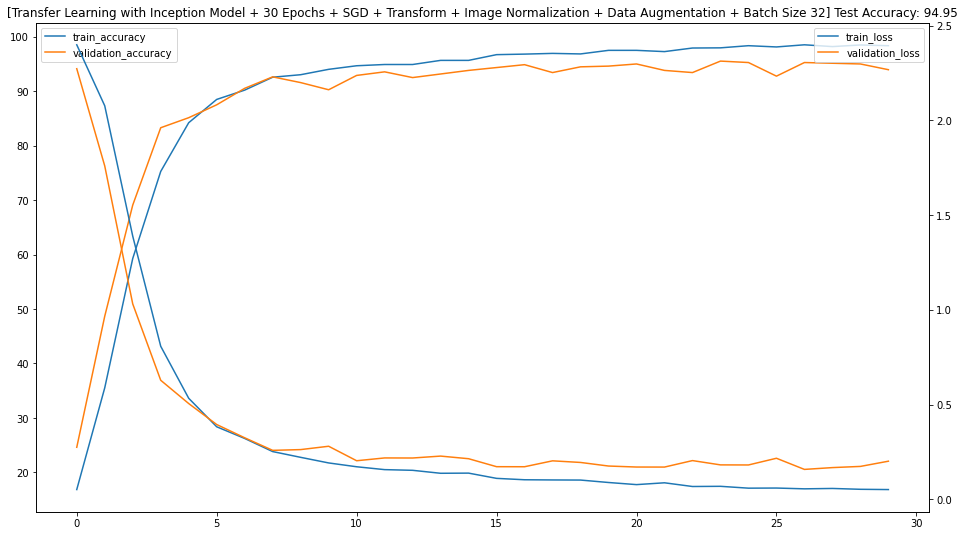

In [26]:
ax = df_experiment9_result[['train_accuracy', 'validation_accuracy']].plot(figsize=(16,9),)
df_experiment9_result[['train_loss', 'validation_loss']].plot(ax=ax.twinx())
ax.set_title(f'[Transfer Learning with Inception Model + 30 Epochs + SGD + Transform + Image Normalization + Data Augmentation + Batch Size 32] Test Accuracy: {test_accuracy_experiment9:.2f}')

In [18]:
image_size = (224, 224)
train_set = SeedlingDataset(
    X_train.file, y_train, '/content/plants/train/',
    transform=transforms.Compose([
        transforms.Resize(size=image_size),
        transforms.ToTensor()]))

means = []
means_sq = []

for img, _ in tqdm_notebook(train_set):
    means.append(np.asarray(img, dtype='float32').mean(axis=(1,2)))
    means_sq.append((np.asarray(img, dtype='float32') ** 2).mean(axis=(1,2)))

mean_img = np.mean(means, axis=0)
std_img = np.sqrt(np.mean(means_sq, axis=0) - (mean_img ** 2))

<ipython-input-18-0e1cf4118983>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img, _ in tqdm_notebook(train_set):


  0%|          | 0/3040 [00:00<?, ?it/s]

# **DENSENET-121 Transfer Learning + 30 Epochs + SGD + Transform + Image Normalization + Data Augmentation + Batch Size 32**

In [20]:
# Load the pretrained model from pytorch
densenet = models.densenet121(pretrained=True)
print(f'Number of output fearurs of pretrained densenet is: {densenet.classifier.out_features}') # 1000

# Freeze training for all layers
for param in densenet.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
classifier_inputs = densenet.classifier.in_features
densenet.classifier = nn.Sequential(
    nn.Linear(classifier_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 12), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

Number of output fearurs of pretrained densenet is: 1000


In [21]:
image_size = (224, 224)
batch_size = 32

train_trans = transforms.Compose([
    transforms.transforms.RandomHorizontalFlip(),
    transforms.transforms.RandomRotation(180),
    transforms.transforms.RandomVerticalFlip(),
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img),
])
validation_trans = transforms.Compose([
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img)
])

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)

learning_rate = 1e-3
densenet_model = densenet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet_model.parameters(), lr=0.001, momentum=0.9)

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

loaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'validation': DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
}
epochs = 30

df_experiment11_result, test_accuracy_experiment11 = run_train_process(epochs, loaders, densenet_model, optimizer, criterion)
df_experiment11_result

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-15-bd074e5d3251>:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
  3%|▎         | 1/30 [01:45<50:49, 105.14s/it]

[0] Train Accuracy: 27.59868 , Validation Accuracy: 50.65789


 20%|██        | 6/30 [09:33<37:32, 93.87s/it]

[5] Train Accuracy: 91.31579 , Validation Accuracy: 90.78947


 37%|███▋      | 11/30 [17:11<29:09, 92.10s/it]

[10] Train Accuracy: 94.93421 , Validation Accuracy: 93.02632


 53%|█████▎    | 16/30 [24:47<21:20, 91.44s/it]

[15] Train Accuracy: 97.20395 , Validation Accuracy: 93.42105


 70%|███████   | 21/30 [32:31<13:54, 92.71s/it]

[20] Train Accuracy: 97.69736 , Validation Accuracy: 95.65789


 87%|████████▋ | 26/30 [40:14<06:10, 92.65s/it]

[25] Train Accuracy: 98.25658 , Validation Accuracy: 95.39474


100%|██████████| 30/30 [46:26<00:00, 92.87s/it]


,train_loss,train_accuracy,validation_loss,validation_accuracy
0,2.237615,27.598684,1.839878,50.657895
1,1.297214,62.434212,0.908173,76.184211
2,0.656468,81.250000,0.530822,84.210526
3,0.406183,87.401314,0.352229,89.868421
4,0.306804,90.032898,0.306732,89.868421
5,0.256235,91.315788,0.279936,90.789474
6,0.237938,91.940788,0.249274,90.921053
7,0.200242,93.848686,0.231985,92.236842
8,0.185569,93.651314,0.224643,91.842105
9,0.159932,94.671051,0.191695,93.157895


Text(0.5, 1.0, '[Transfer Learning with DENSENET121 + 30 Epochs + SGD + Transform + Image Normalization + Data Augmentation + Batch Size 32] Test Accuracy: 95.26')

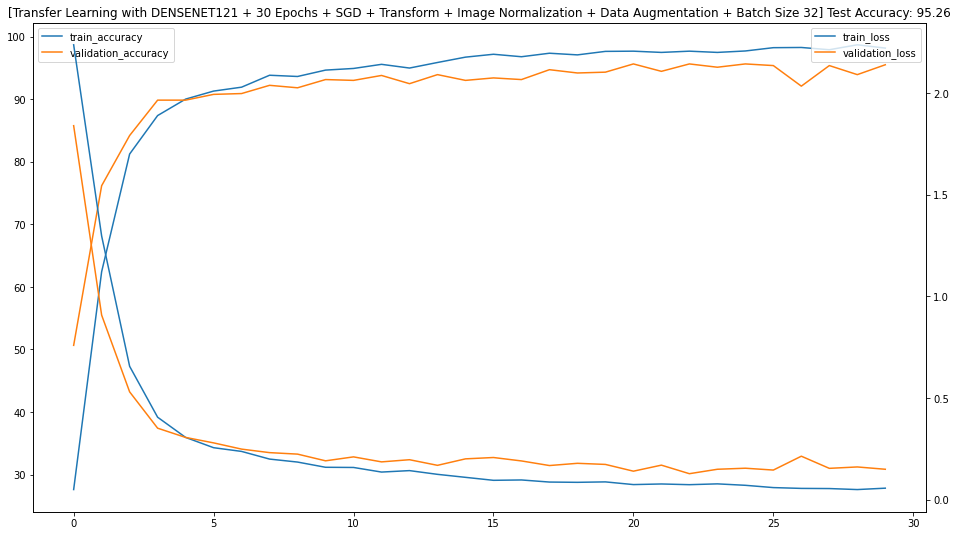

In [22]:
ax = df_experiment11_result[['train_accuracy', 'validation_accuracy']].plot(figsize=(16,9),)
df_experiment11_result[['train_loss', 'validation_loss']].plot(ax=ax.twinx())
ax.set_title(f'[Transfer Learning with DENSENET121 + 30 Epochs + SGD + Transform + Image Normalization + Data Augmentation + Batch Size 32] Test Accuracy: {test_accuracy_experiment11:.2f}')

# **SQUEEZENET Transfer Learning + 30 Epochs + SGD + Transform + Image Normalization + Data Augmentation + Batch Size 32**

In [27]:
# Load the pretrained model from pytorch
squeezenet = models.squeezenet1_0(pretrained=True)

# Freeze training for all layers
for param in squeezenet.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
squeezenet.classifier[1] = nn.Conv2d(512, 12, kernel_size=(1,1), stride=(1,1))

squeezenet.num_classes = 12


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
image_size = (224, 224)
batch_size = 32

train_trans = transforms.Compose([
    transforms.transforms.RandomHorizontalFlip(),
    transforms.transforms.RandomRotation(180),
    transforms.transforms.RandomVerticalFlip(),
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img),
])
validation_trans = transforms.Compose([
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img)
])

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)

learning_rate = 1e-3
squeezenet_model = squeezenet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(squeezenet_model.parameters(), lr=0.001, momentum=0.9)

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

loaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'validation': DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
}
epochs = 30

df_experiment12_result, test_accuracy_experiment12 = run_train_process(epochs, loaders, squeezenet_model, optimizer, criterion)
df_experiment12_result

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-15-bd074e5d3251>:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
  3%|▎         | 1/30 [01:13<35:44, 73.94s/it]

[0] Train Accuracy: 39.04605 , Validation Accuracy: 70.65789


 20%|██        | 6/30 [07:01<27:40, 69.18s/it]

[5] Train Accuracy: 89.40790 , Validation Accuracy: 91.84211


 37%|███▋      | 11/30 [12:44<21:45, 68.72s/it]

[10] Train Accuracy: 91.67764 , Validation Accuracy: 93.15789


 53%|█████▎    | 16/30 [18:20<15:40, 67.14s/it]

[15] Train Accuracy: 94.17764 , Validation Accuracy: 94.47368


 70%|███████   | 21/30 [23:52<10:00, 66.68s/it]

[20] Train Accuracy: 94.67105 , Validation Accuracy: 95.13158


 87%|████████▋ | 26/30 [29:26<04:27, 66.87s/it]

[25] Train Accuracy: 96.41447 , Validation Accuracy: 96.84211


100%|██████████| 30/30 [33:51<00:00, 67.73s/it]


,train_loss,train_accuracy,validation_loss,validation_accuracy
0,1.820059,39.046051,0.907678,70.657895
1,0.764795,74.078949,0.337166,88.815789
2,0.450500,85.065788,0.537120,80.921053
3,0.419850,85.493423,0.273518,89.210526
4,0.331273,88.059212,0.318593,88.026316
5,0.317607,89.407898,0.211178,91.842105
6,0.324929,88.355263,0.268974,89.210526
7,0.240915,91.085526,0.297660,88.684211
8,0.227158,91.578949,0.253745,92.105263
9,0.246687,91.315788,0.214529,92.631579


Text(0.5, 1.0, '[Transfer Learning with SqueezeNet + 30 Epochs + SGD + Transform + Image Normalization + Data Augmentation + Batch Size 32] Test Accuracy: 94.11')

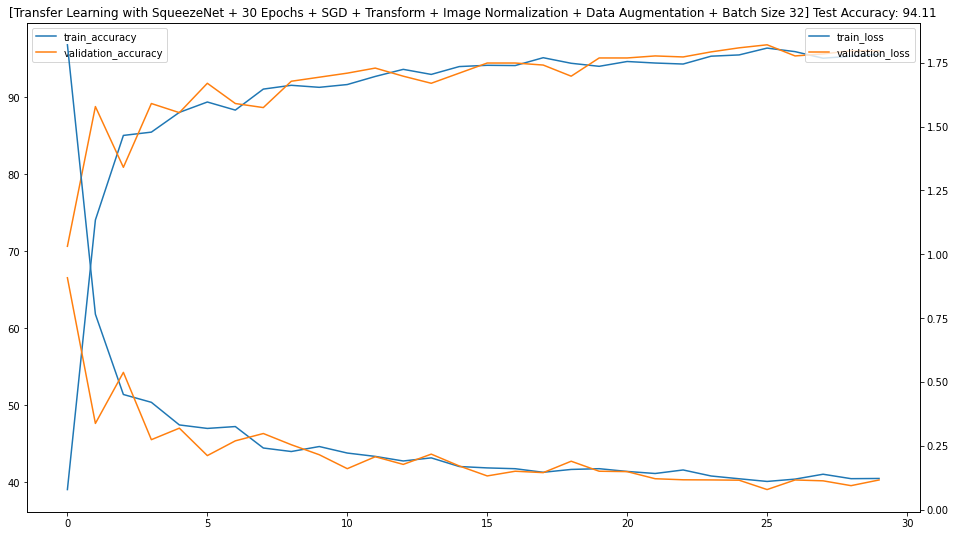

In [29]:
ax = df_experiment12_result[['train_accuracy', 'validation_accuracy']].plot(figsize=(16,9),)
df_experiment12_result[['train_loss', 'validation_loss']].plot(ax=ax.twinx())
ax.set_title(f'[Transfer Learning with SqueezeNet + 30 Epochs + SGD + Transform + Image Normalization + Data Augmentation + Batch Size 32] Test Accuracy: {test_accuracy_experiment12:.2f}')

# **EfficientNet Transfer Learning + 30 Epochs + SGD + Transform + Image Normalization + Data Augmentation + Batch Size 32**

In [19]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=2ad171f0047baf8e55cf6a66c7db9cf4f0186acd8a1fd1025ece7bcf801045aa
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
Successfully built efficientnet_pytorch


In [20]:
from efficientnet_pytorch import EfficientNet
efficientnet = EfficientNet.from_pretrained('efficientnet-b1')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b1


In [21]:
# Freeze training for all layers
for param in efficientnet.parameters():
    param.require_grad = False

num_ftrs = efficientnet._fc.in_features

fc_inputs = efficientnet._fc.in_features
efficientnet.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 12), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [22]:
image_size = (224, 224)
batch_size = 32

train_trans = transforms.Compose([
    transforms.transforms.RandomHorizontalFlip(),
    transforms.transforms.RandomRotation(180),
    transforms.transforms.RandomVerticalFlip(),
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img),
])
validation_trans = transforms.Compose([
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img)
])

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)

learning_rate = 1e-3
efficientnet_model = efficientnet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(efficientnet_model.parameters(), lr=0.001, momentum=0.9)

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

loaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'validation': DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
}
epochs = 30

df_experiment13_result, test_accuracy_experiment13 = run_train_process(epochs, loaders, efficientnet_model, optimizer, criterion)
df_experiment13_result

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-15-bd074e5d3251>:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
  3%|▎         | 1/30 [01:38<47:27, 98.18s/it]

[0] Train Accuracy: 6.08553 , Validation Accuracy: 22.89474


 20%|██        | 6/30 [08:40<34:04, 85.20s/it]

[5] Train Accuracy: 88.84869 , Validation Accuracy: 86.57895


 37%|███▋      | 11/30 [15:43<26:51, 84.80s/it]

[10] Train Accuracy: 92.63158 , Validation Accuracy: 88.94737


 53%|█████▎    | 16/30 [22:44<19:39, 84.28s/it]

[15] Train Accuracy: 94.40790 , Validation Accuracy: 92.23684


 70%|███████   | 21/30 [29:49<12:43, 84.84s/it]

[20] Train Accuracy: 95.49342 , Validation Accuracy: 91.71053


 87%|████████▋ | 26/30 [36:51<05:38, 84.53s/it]

[25] Train Accuracy: 96.77631 , Validation Accuracy: 91.71053


100%|██████████| 30/30 [42:29<00:00, 84.97s/it]


,train_loss,train_accuracy,validation_loss,validation_accuracy
0,6.123090,6.085526,4.522045,22.894737
1,2.699478,52.401318,1.570646,70.657895
2,0.951338,76.973686,0.808564,80.526316
3,0.549807,85.164474,0.616456,82.763158
4,0.434155,86.875000,0.519757,85.131579
5,0.349278,88.848686,0.453668,86.578947
6,0.324408,89.111839,0.392992,88.815789
7,0.281546,91.118423,0.337196,89.605263
8,0.225614,92.467102,0.344482,89.210526
9,0.227255,92.467102,0.363240,89.605263


Text(0.5, 1.0, '[Transfer Learning with EfficientNet + 30 Epochs + SGD + Transform + Image Normalization + Data Augmentation + Batch Size 32] Test Accuracy: 91.26')

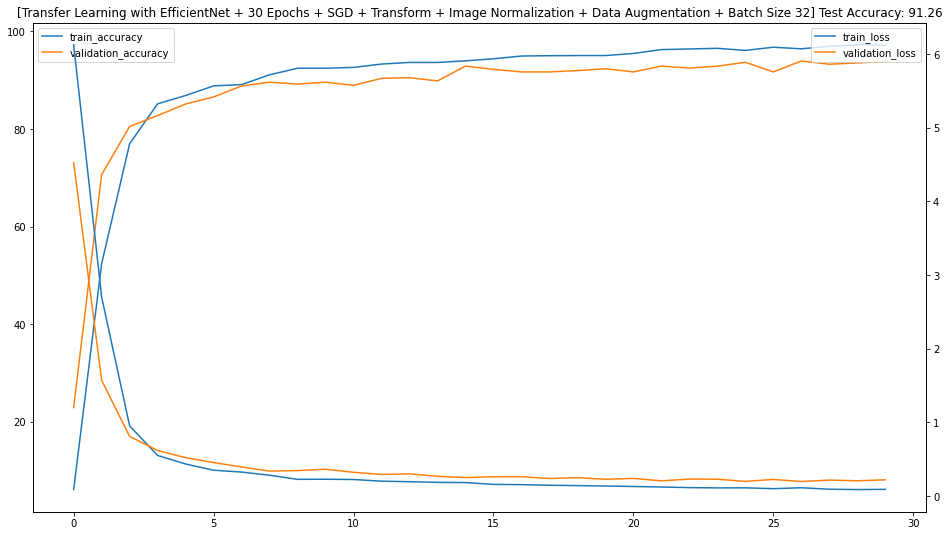

In [23]:
ax = df_experiment13_result[['train_accuracy', 'validation_accuracy']].plot(figsize=(16,9),)
df_experiment13_result[['train_loss', 'validation_loss']].plot(ax=ax.twinx())
ax.set_title(f'[Transfer Learning with EfficientNet + 30 Epochs + SGD + Transform + Image Normalization + Data Augmentation + Batch Size 32] Test Accuracy: {test_accuracy_experiment13:.2f}')